In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create the a csv to import the information to hawaii.sqlite
csv_file_path1 = "./Resources/hawaii_stations.csv"
csv_file_path2 = "./Resources/hawaii_measurements.csv"

df1= pd.read_csv(csv_file_path1)
df2= pd.read_csv(csv_file_path2)

merged_df = pd.merge(df1, df2, on='station', how='inner')

merged_df.to_csv('./Resources/hawaii.csv',index= False)


In [5]:
import sqlite3
data_file = "./Resources/hawaii.sqlite"
conn = sqlite3.connect(data_file)
cursor = conn.cursor()

cursor.execute("select name from sqlite_master where type='table';")

tables = cursor.fetchall()

for table in tables:
    print(table[0])

conn.close()

measurement
station


In [6]:
# create engine to hawaii.sqlite
connection_string = "sqlite:///Resources/hawaii.sqlite"
engine = create_engine(connection_string)
#conn = engine.connect()
#hawaii= pd.read_sql("SELECT * FROM measurement", conn)
#hawaii

In [7]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station= Base.classes.station
Measurement=Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date= session.query(func.max(Measurement.date)).scalar()
most_recent_date


'2017-08-23'

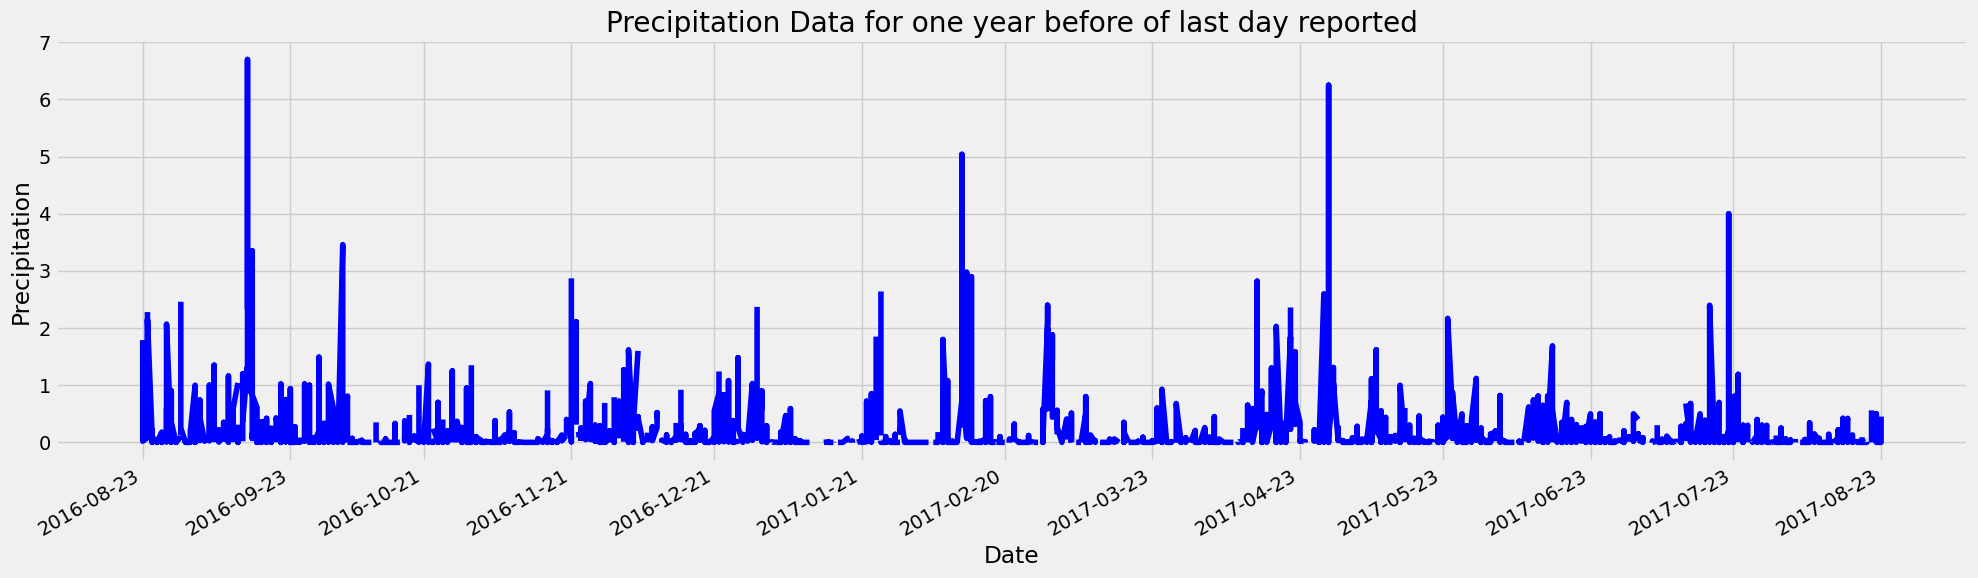

In [115]:
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.dates as mdates

# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date,'%Y-%m-%d')
most_recent_date
# Calculate the date one year from the last date in data set.
one_year_before= most_recent_date - relativedelta(years=1)
one_year_before= one_year_before.strftime('%Y-%m-%d')
one_year_before

# Perform a query to retrieve the data and precipitation scores
one_year_before_data= session.query(Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).filter(Measurement.date >= one_year_before).all()
one_year_before_data
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_one_year_before_data = pd.DataFrame(one_year_before_data)


# Sort the dataframe by date
df_one_year_before_data = df_one_year_before_data.sort_values(by='date')
df_one_year_before_data

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,6))
plt.plot(df_one_year_before_data['date'],df_one_year_before_data['prcp'], color='b')
plt.title('Precipitation Data for one year before of last day reported')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.tight_layout()
plt.show()


In [120]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics= df_one_year_before_data['prcp'].describe()
summary_statistics

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations= func.count().distinct().label('total_stations')
query = session.query(total_stations).select_from(Station)
result = query.scalar()
result

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_station= (session.query(Measurement.station,
              func.count().label('station_count'))
       .group_by(Measurement.station)
       .order_by(func.count().desc())
       .first())
most_active_station




('USC00519281', 2772)

In [139]:
#Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id= most_active_station.station

query=(session.query(
        func.min(Measurement.tobs).label('min_temperature'),
        func.max(Measurement.tobs).label('max_temperature'),
        func.avg(Measurement.tobs).label('avg_temperature')
)
.filter(Measurement.station== most_active_station_id)
.group_by(Measurement.station)
)

temp_stats= query.one()
temp_stats


(54.0, 85.0, 71.66378066378067)

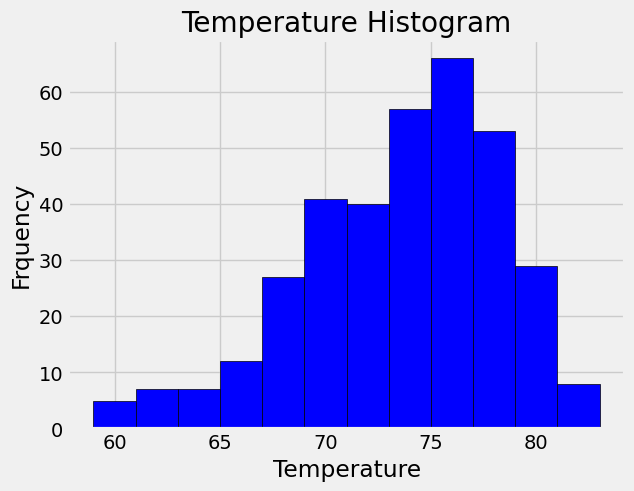

In [150]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_one_year= (session.query(Measurement.tobs)
                       .filter(Measurement.station == most_active_station_id,
                               Measurement.date >= one_year_before)).all()

plt.hist(np.ravel(temperature_one_year),bins=12, color='b',edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frquency')
plt.title('Temperature Histogram')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()